# SpatioTemporal Kernel Density Estimation

In [2]:
import math, os, sys
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
from scipy import spatial
from tqdm import tqdm
from STKDE import sett, kde
from STKDE import calculate as calc

In [2]:
# Initialize
sett.init()

#read parameters
parameters = {'p1' : 3000.0, 'p2' : 24.0, 'p3' : 1000.0, 'p4' : 2.0}

sett.p1 = float(parameters['p1'])	# p1 = spatial bandwidth(meter)
sett.p2 = float(parameters['p2'])	# p2 = temporal bandwidth(hour)
sett.p3 = float(parameters['p3'])	# p3 = spatial resolution(meter)
sett.p4 = int(parameters['p4'])	    # p4 = temporal resolution(hour)

In [3]:
# Load Data
df = gpd.read_file('data/gdf_crime_DJ.gpkg')
df = df.to_crs(epsg=5181) # 좌표계 m단위로 변경
df = df[['RECV_CPLT_DM', 'geometry']]
df.RECV_CPLT_DM = df.RECV_CPLT_DM.dt.to_period('H')
df.RECV_CPLT_DM = df.RECV_CPLT_DM.dt.to_timestamp()

# data에 time index 찾아 넣기(기준시점으로부터 시간)

df['T'] = 0.0
for i in range(len(df)):
    # 2021년 1월 1일 0시 기준
    delta = df.RECV_CPLT_DM[i] - pd.Timestamp(2021, 1, 1, 0) 
    df.iat[i, 2] = delta / pd.Timedelta(hours=1)

# X, Y 좌표 추출
df['X'] = df.geometry.x
df['Y'] = df.geometry.y

df.head(3) # print example dataset

# df.to_csv('STKDE/data.csv', index=False)

,RECV_CPLT_DM,geometry,T,X,Y
0,2021-01-01 13:00:00,POINT (234583.991 313824.286),13.0,234583.990891,313824.286095
1,2021-01-03 18:00:00,POINT (236327.938 316034.748),66.0,236327.937925,316034.747619
2,2021-01-04 09:00:00,POINT (240145.107 315535.596),81.0,240145.107404,315535.595667


In [4]:
# 각 벡터 분리
inX = df['X']
inY = df['Y']
inT = df['T'].to_numpy().reshape(-1,1)

inXY = list(zip(inX, inY))

In [5]:
# 전역변수 설정(global variables)
sett.npts = len(df)
sett.ct1 = 0.5 * math.pi
sett.ct2 = pow(10.0, 5) / (sett.npts * pow(sett.p1, 2) * sett.p2)

In [6]:
# 격자데이터 로드, 격자화
grid = gpd.read_file('data/CENSUS/grid_DJ.gpkg') # epsg:5181
xyGrid = list(zip(grid.geometry.centroid.x, grid.geometry.centroid.y))

# X,Y 및 T의 범위(최대, 최소) 확인
tmin, tmax = 0.0, max(inT)

tminDiff = tmin%sett.p4
tmaxDiff = tmax%sett.p4

tminP = tmin - tminDiff + sett.p4
tmaxP = tmax - tmaxDiff + sett.p4

tGrid = []
for k in range(int(tminP),int(tmaxP),sett.p4):
    tGrid.append([k])

In [7]:
#build trees

stree = spatial.cKDTree(inXY)
ttree = spatial.cKDTree(inT)

sList = stree.query_ball_point(xyGrid, r=sett.p1)
tList = ttree.query_ball_point(tGrid, r=sett.p2)

print(f'Built cKDTree! : total len = {len(sList)*len(tList)}')

Built cKDTree! : total len = 2765000


In [8]:
# Using Multiprocessing Pool
from itertools import product

stList = []
stList_app = stList.append # 속도향상

with tqdm(total=len(sList)*len(tList)) as pbar:
    for i,j in product(range(len(sList)), range(len(tList))):
        xC, yC, tC = xyGrid[i][0], xyGrid[i][1], tGrid[j][0] # current grid (X,Y : Centroid)

        # nList > points that are neighbors both spatially and temporally
        nList = [val for val in sList[i] if val in tList[j]]
        density = 0.0 # estimated density
        
        # calculate density
        if nList: # neighbor 존재하면 density 추가
            for k in nList:
                nindex = int(k)
                density += kde.densityF(
                    inXY[nindex][0], inXY[nindex][1], 
                    inT[nindex][0], xC, yC, tC)
            
            # save density for point
        stList_app([xC, yC, tC, density])
        pbar.update(1)

stList = pd.DataFrame(stList, columns=['X', 'Y', 'T', 'density'])
stList.to_csv(f'STKDE/result/DJ_sb_{int(sett.p1)}_tb_{int(sett.p2)}.csv', index=False)
print('STKDE completed!')

100%|██████████| 2765000/2765000 [01:33<00:00, 29698.06it/s] 


STKDE completed!


In [3]:
grid = gpd.read_file('data/CENSUS/grid_DJ.gpkg') # load grid information
result_grid = stList.groupby(['X','Y'], as_index=False).sum()
result_grid = gpd.GeoDataFrame(result_grid['density'], geometry=gpd.points_from_xy(result_grid.X, result_grid.Y), crs='epsg:5181')

# 격자에 병합
grid = grid.sjoin(result_grid, how='left')

NameError: name 'stList' is not defined

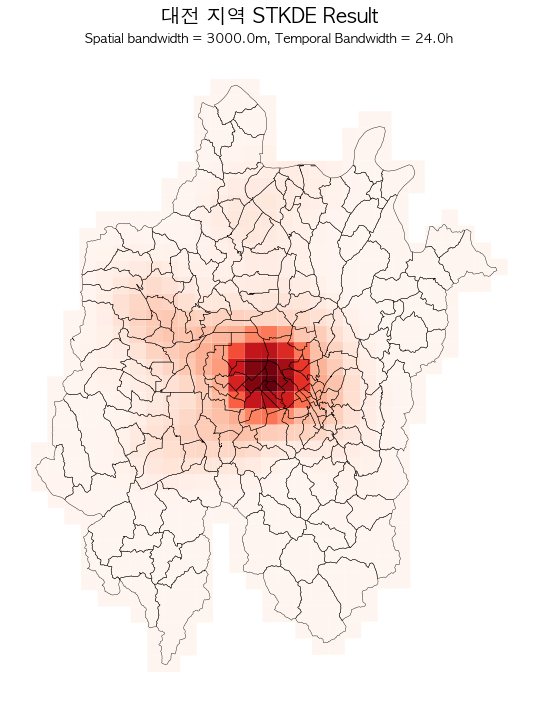

In [17]:
# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# for korean plotting
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

from matplotlib.colors import ListedColormap

daejeon = gpd.read_file('data/ADM_AREA/대전/LSMD_ADM_SECT_UMD_30.shp', encoding='cp949').to_crs(epsg=5181)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10))
daejeon.boundary.plot(ax=ax, zorder=2, color='black', linewidth = 0.4)
grid.plot(column = 'density',ax=ax, zorder=1, cmap='Reds')
# gdf_crime.geometry.plot(ax=ax, zorder=2, color='red', alpha=0.1, markersize=2)

ax.set_axis_off()

plt.suptitle('대전 지역 STKDE Result', fontsize=20)
plt.title(f'Spatial bandwidth = {sett.p1}m, Temporal Bandwidth = {sett.p2}h', fontsize=13)
plt.tight_layout()
plt.savefig(f'plot/대전 지역 내 보이스피싱 핫스팟_sb_{int(sett.p1)}_tb_{int(sett.p2)}.png', facecolor='white')
plt.show()